In [1]:
# Scripts Installation Path: 'C:\Users\Talha\AppData\Local\Programs\Python\Python312\Scripts'

# Libraries installed: 
# 1. diffusers
# 2. transformers
# 3. accelerate
# 4. hf_xet

import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt


import torch, transformers, shutil, os

from diffusers                              import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
# from source_code.source_unet_2d_condition   import UNet2DConditionModel
from transformers                           import CLIPTextModel, CLIPTokenizer
from torchinfo                              import summary
from PIL                                    import Image
from torchvision                            import transforms as tfms
from tqdm.auto                              import tqdm
from IPython.display                        import display, clear_output
from torchsummary                           import summary as summ

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/ee/anaconda3/envs/TaN2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## Initiating tokenizer and encoder.
tokenizer    = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

## Initiating the VAE
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16).to(device)

## Initializing a scheduler and Setting number of sampling steps
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
scheduler.set_timesteps(50)

## Initializing the U-Net model
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to(device)

In [ ]:
# Steps to run VAE (83.65 Million Params)

# 1) Make sure input is dtype torch.float16 and on the same device as the model.
# 2) The forward pass consists of 3 steps
#    i)   posterior  = vae.encode(inputs).latent_dist --> gives a DiagnolGaussianDistribution Object which has the mean, logvar etc as its self members
#    ii)  pos_sample = posterior.sample() --> simply returns a latent representation sample by x = self.mean + self.std * epsilon (of same shape as self.mean) with 
#         latent_dim = H/8, W /8
#    iii) recon      = vae.decode(pos_sample).sample --> returns the reconstruction which is logits I believe.

# Example Usage
# >>> inputs = torch.randn(1, 3, 256, 256).to(torch.float16).to('cuda')
# >>> recon  = vae(inputs)

In [3]:
## Helper functions
def load_image(p):
    '''
    Function to load images from a defined path
    '''
    return Image.open(p).convert('RGB').resize((512,512))

def pil_to_latents(image):
    '''
    Function to convert image to latents
    '''
    init_image = tfms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
    init_image = init_image.to(device="cuda", dtype=torch.float16) 
    init_latent_dist = vae.encode(init_image).latent_dist.sample() * 0.18215
    return init_latent_dist

def latents_to_pil(latents):
    '''
    Function to convert latents to images
    '''
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images


def text_enc(prompts, maxlen=None):
    '''
    A function to take a texual promt and convert it into embeddings
    '''
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt") 
    return text_encoder(inp.input_ids.to("cuda"))[0].half()


In [4]:
prompts = 'Sharks eating black cat'
bs      = len(prompts) # 19
text    = text_enc(prompts) # (1, 77, 768) 
uncond  = text_enc([''] * bs, text.shape[1]) # (19, 77, 768)
emb     = torch.cat([uncond, text])          # (20, 77, 768) 

emb_filtered     = emb[:2, :, :]

print(f'text_encoding shape: {text.shape}, uncond_text.shape: {uncond.shape}, emb.shape: {emb.shape}, emb_filtered {emb_filtered.shape}')  


text_encoding shape: torch.Size([1, 77, 768]), uncond_text.shape: torch.Size([23, 77, 768]), emb.shape: torch.Size([24, 77, 768]), emb_filtered torch.Size([2, 77, 768])


In [5]:
# Instanting random noise which will be noised and feeded to unet along with prompt. Note see 'https://huggingface.co/CompVis/stable-diffusion-v1-4/blob/main/unet/config.json' for the config for unet in SD 1.4
dim = 512
latents = torch.randn((bs, unet.config.in_channels, dim//8, dim//8))# Initiating random noise

# Setting number of steps in scheduler
scheduler.set_timesteps(70)

# Adding noise to the latents 
latents = latents.to("cuda").half() * scheduler.init_noise_sigma
latents.shape

torch.Size([23, 4, 64, 64])

In [6]:
ts = 999.0
inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
inp_filtered = inp[:2, :, :]
# Predicting noise residual using U-Net
print(f'ts: {ts}, inp.shape {inp_filtered.shape}, emb.shape {emb_filtered.shape}')
# with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)

ts: 999.0, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])


In [19]:
def prompt_2_img(prompts, g=7.5, seed=100, steps=70, dim=512, save_int=True):
    """
    Diffusion process to convert prompt to image
    """
    
    # Defining batch size
    bs = len(prompts) 
    
    # Converting textual prompts to embedding
    text = text_enc(prompts) 
    
    # Adding an unconditional prompt , helps in the generation process
    uncond =  text_enc([""] * bs, text.shape[1])
    emb    = torch.cat([uncond, text])
    
    # Setting the seed
    if seed: torch.manual_seed(seed)
    
    # Initiating random noise
    latents = torch.randn((bs, unet.config.in_channels, dim//8, dim//8))
    
    # Setting number of steps in scheduler
    scheduler.set_timesteps(steps)
    
    # Adding noise to the latents 
    latents = latents.to("cuda").half() * scheduler.init_noise_sigma

    print("Processing text prompts:", prompts)
    # Just before the loop starts:
    print("Visualizing initial latents...")
    latents_norm = torch.norm(latents.view(latents.shape[0], -1), dim=1).mean().item()
    print(f"Initial Latents Norm: {latents_norm}")

    # Iterating through defined steps
    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        # We need to scale the i/p latents to match the variance
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        
        # Predicting noise residual using U-Net
        print(f'ts: {ts}, inp.shape {inp.shape}, emb.shape {emb.shape}')
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
            
        # Performing Guidance
        pred = u + g*(t-u)
        
        # Conditioning  the latents
        latents = scheduler.step(pred, ts, latents).prev_sample
        
        # Inside your loop, after `latents` have been updated:
        latents_norm = torch.norm(latents.view(latents.shape[0], -1), dim=1).mean().item()
        print(f"Step {i+1}/{steps} Latents Norm: {latents_norm}")
        
        from IPython.display import display, clear_output
        if save_int and i%10==0: 
            image_path = f'steps2/la_{i:04d}.jpeg'
            latents_to_pil(latents)[0].save(image_path)
            display(latents_to_pil(latents)[0])  # Display the new image

    return latents_to_pil(latents)

Processing text prompts: ['Sharks eating black cat']
Visualizing initial latents...
Initial Latents Norm: 1878.0


  0%|          | 0/70 [00:00<?, ?it/s]

ts: 999.0, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 1/70 Latents Norm: 1721.0


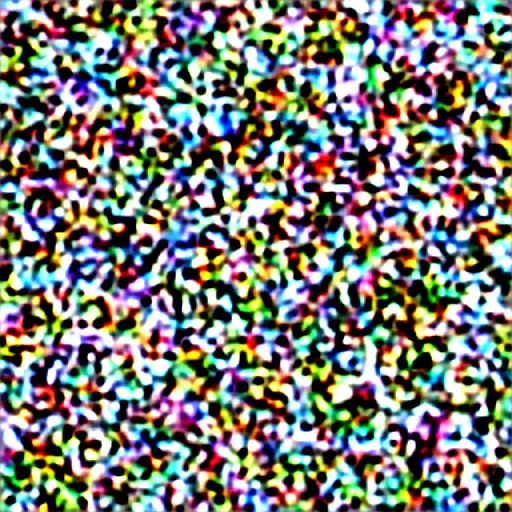

  4%|▍         | 3/70 [00:00<00:12,  5.54it/s]

ts: 984.521728515625, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 2/70 Latents Norm: 1581.0
ts: 970.04345703125, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 3/70 Latents Norm: 1455.0
ts: 955.5652465820312, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])


  9%|▊         | 6/70 [00:00<00:08,  7.92it/s]

Step 4/70 Latents Norm: 1341.0
ts: 941.0869750976562, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 5/70 Latents Norm: 1238.0
ts: 926.6087036132812, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 6/70 Latents Norm: 1146.0
ts: 912.1304321289062, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])


 11%|█▏        | 8/70 [00:01<00:07,  8.61it/s]

Step 7/70 Latents Norm: 1062.0
ts: 897.6521606445312, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 8/70 Latents Norm: 985.5
ts: 883.1738891601562, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])


 14%|█▍        | 10/70 [00:01<00:06,  9.23it/s]

Step 9/70 Latents Norm: 916.5
ts: 868.6956787109375, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 10/70 Latents Norm: 854.0
ts: 854.2174072265625, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 11/70 Latents Norm: 796.5


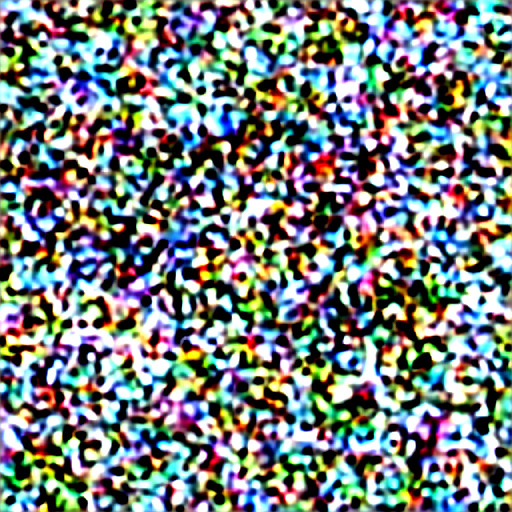

 17%|█▋        | 12/70 [00:01<00:09,  5.95it/s]

ts: 839.7391357421875, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 12/70 Latents Norm: 744.0
ts: 825.2608642578125, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])


 20%|██        | 14/70 [00:02<00:07,  7.18it/s]

Step 13/70 Latents Norm: 696.5
ts: 810.7825927734375, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 14/70 Latents Norm: 652.5
ts: 796.3043212890625, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])


 23%|██▎       | 16/70 [00:02<00:06,  8.13it/s]

Step 15/70 Latents Norm: 612.5
ts: 781.8261108398438, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 16/70 Latents Norm: 576.0
ts: 767.3478393554688, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])


 26%|██▌       | 18/70 [00:02<00:06,  8.56it/s]

Step 17/70 Latents Norm: 542.0
ts: 752.8695678710938, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 18/70 Latents Norm: 511.0
ts: 738.3912963867188, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])


 29%|██▊       | 20/70 [00:02<00:05,  9.02it/s]

Step 19/70 Latents Norm: 482.5
ts: 723.9130249023438, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 20/70 Latents Norm: 456.25
ts: 709.4347534179688, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 21/70 Latents Norm: 432.0


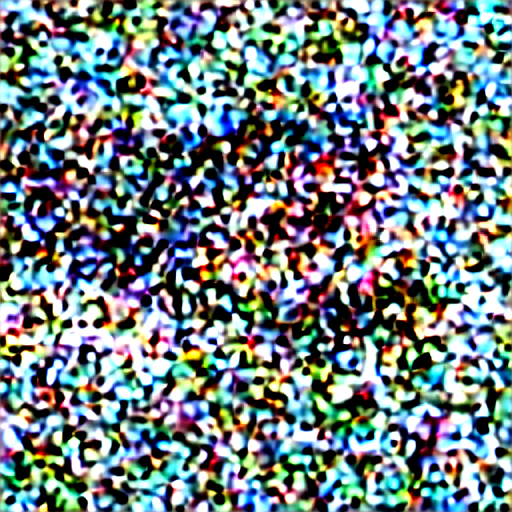

 31%|███▏      | 22/70 [00:03<00:08,  5.67it/s]

ts: 694.95654296875, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 22/70 Latents Norm: 409.5
ts: 680.478271484375, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])


 34%|███▍      | 24/70 [00:03<00:06,  6.81it/s]

Step 23/70 Latents Norm: 388.75
ts: 666.0, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 24/70 Latents Norm: 369.5
ts: 651.521728515625, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])


 37%|███▋      | 26/70 [00:03<00:06,  6.85it/s]

Step 25/70 Latents Norm: 351.5
ts: 637.04345703125, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 26/70 Latents Norm: 335.0
ts: 622.5652465820312, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])


 40%|████      | 28/70 [00:04<00:05,  7.89it/s]

Step 27/70 Latents Norm: 319.5
ts: 608.0869750976562, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 28/70 Latents Norm: 305.25
ts: 593.6087036132812, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])


 43%|████▎     | 30/70 [00:04<00:04,  8.54it/s]

Step 29/70 Latents Norm: 292.0
ts: 579.1304321289062, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 30/70 Latents Norm: 279.5
ts: 564.6521606445312, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 31/70 Latents Norm: 268.0


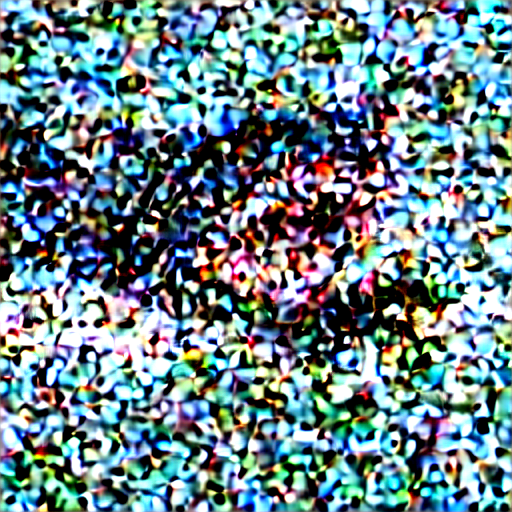

 46%|████▌     | 32/70 [00:04<00:07,  5.28it/s]

ts: 550.1738891601562, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 32/70 Latents Norm: 257.25
ts: 535.6956787109375, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])


 49%|████▊     | 34/70 [00:05<00:05,  6.22it/s]

Step 33/70 Latents Norm: 247.125
ts: 521.2174072265625, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 34/70 Latents Norm: 237.625
ts: 506.7391357421875, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])


 51%|█████▏    | 36/70 [00:05<00:04,  7.19it/s]

Step 35/70 Latents Norm: 228.875
ts: 492.2608642578125, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 36/70 Latents Norm: 220.625
ts: 477.7826232910156, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])


 54%|█████▍    | 38/70 [00:05<00:04,  7.82it/s]

Step 37/70 Latents Norm: 212.875
ts: 463.3043518066406, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 38/70 Latents Norm: 205.625
ts: 448.8260803222656, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])


 57%|█████▋    | 40/70 [00:05<00:03,  7.84it/s]

Step 39/70 Latents Norm: 198.75
ts: 434.34783935546875, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 40/70 Latents Norm: 192.375
ts: 419.86956787109375, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 41/70 Latents Norm: 186.375


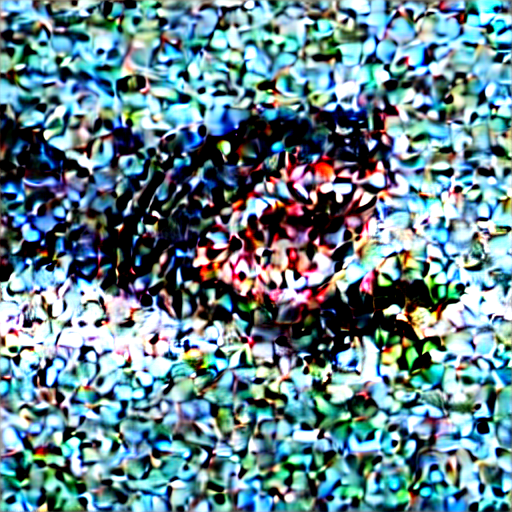

 60%|██████    | 42/70 [00:06<00:05,  4.78it/s]

ts: 405.39129638671875, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 42/70 Latents Norm: 180.75
ts: 390.9130554199219, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])


 63%|██████▎   | 44/70 [00:06<00:04,  5.48it/s]

Step 43/70 Latents Norm: 175.375
ts: 376.4347839355469, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 44/70 Latents Norm: 170.375
ts: 361.9565124511719, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])


 66%|██████▌   | 46/70 [00:06<00:03,  6.48it/s]

Step 45/70 Latents Norm: 165.75
ts: 347.478271484375, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 46/70 Latents Norm: 161.25
ts: 333.0, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])


 69%|██████▊   | 48/70 [00:07<00:03,  6.91it/s]

Step 47/70 Latents Norm: 157.125
ts: 318.521728515625, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 48/70 Latents Norm: 153.25
ts: 304.0434875488281, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])


 71%|███████▏  | 50/70 [00:07<00:02,  6.91it/s]

Step 49/70 Latents Norm: 149.5
ts: 289.5652160644531, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 50/70 Latents Norm: 146.125
ts: 275.0869445800781, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 51/70 Latents Norm: 142.875


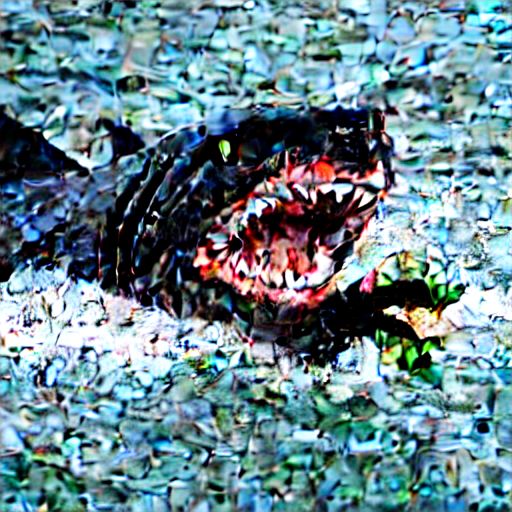

 74%|███████▍  | 52/70 [00:08<00:03,  4.87it/s]

ts: 260.60870361328125, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 52/70 Latents Norm: 139.75
ts: 246.13043212890625, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])


 77%|███████▋  | 54/70 [00:08<00:02,  5.82it/s]

Step 53/70 Latents Norm: 136.875
ts: 231.6521759033203, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 54/70 Latents Norm: 134.125
ts: 217.17391967773438, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])


 80%|████████  | 56/70 [00:08<00:02,  6.57it/s]

Step 55/70 Latents Norm: 131.625
ts: 202.69564819335938, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 56/70 Latents Norm: 129.25
ts: 188.21739196777344, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])


 83%|████████▎ | 58/70 [00:08<00:01,  6.75it/s]

Step 57/70 Latents Norm: 126.9375
ts: 173.7391357421875, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 58/70 Latents Norm: 124.875
ts: 159.2608642578125, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])


 86%|████████▌ | 60/70 [00:09<00:01,  7.35it/s]

Step 59/70 Latents Norm: 122.875
ts: 144.78260803222656, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 60/70 Latents Norm: 121.0
ts: 130.30435180664062, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 61/70 Latents Norm: 119.25


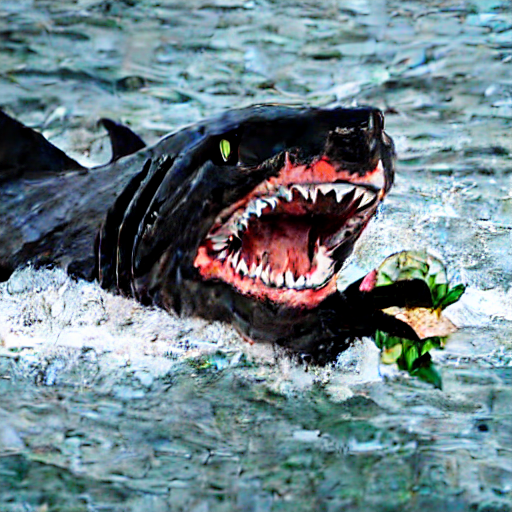

 89%|████████▊ | 62/70 [00:09<00:01,  4.69it/s]

ts: 115.82608795166016, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 62/70 Latents Norm: 117.625
ts: 101.34782409667969, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])


 91%|█████████▏| 64/70 [00:10<00:01,  5.54it/s]

Step 63/70 Latents Norm: 116.125
ts: 86.86956787109375, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 64/70 Latents Norm: 114.6875
ts: 72.39130401611328, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])


 94%|█████████▍| 66/70 [00:10<00:00,  5.74it/s]

Step 65/70 Latents Norm: 113.375
ts: 57.91304397583008, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 66/70 Latents Norm: 112.1875
ts: 43.434783935546875, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])


 97%|█████████▋| 68/70 [00:10<00:00,  6.13it/s]

Step 67/70 Latents Norm: 111.0625
ts: 28.95652198791504, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])
Step 68/70 Latents Norm: 110.0
ts: 14.47826099395752, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])


 99%|█████████▊| 69/70 [00:10<00:00,  6.50it/s]

Step 69/70 Latents Norm: 109.0
ts: 0.0, inp.shape torch.Size([2, 4, 64, 64]), emb.shape torch.Size([2, 77, 768])


100%|██████████| 70/70 [00:11<00:00,  6.31it/s]

Step 70/70 Latents Norm: 108.9375


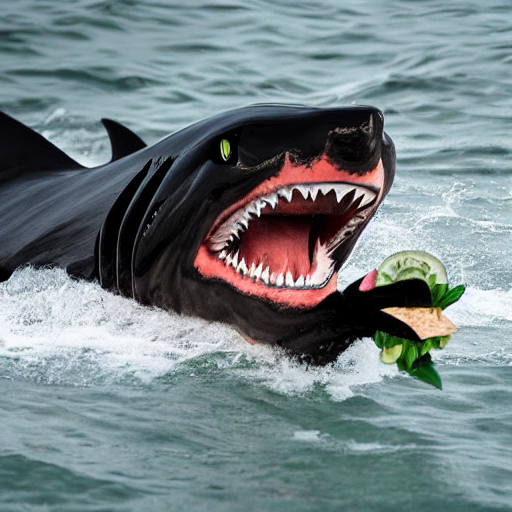

In [20]:
images = prompt_2_img([prompts], save_int=True)
for img in images:display(img)
